In [58]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetch Brent Crude Oil Data
def get_brent_data():
    # Brent Crude Oil symbol in Yahoo Finance is 'BZ=F'
    brent = yf.download('BZ=F', period='2y', interval='1d')
    brent.dropna(inplace=True)
    return brent

# Calculate Technical Indicators
def calculate_technical_indicators(df):
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()

    # Simple Moving Averages
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    # Exponential Moving Averages
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()

    # RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = delta.copy()
    loss = delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = abs(loss.rolling(window=14).mean())
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    sma20 = df['Close'].rolling(window=20).mean()
    std20 = df['Close'].rolling(window=20).std()
    df['BB_upper'] = sma20 + (std20 * 2)
    df['BB_middle'] = sma20
    df['BB_lower'] = sma20 - (std20 * 2)

    # MACD (Moving Average Convergence Divergence)
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_hist'] = df['MACD'] - df['MACD_signal']

    # ATR (Average True Range)
    high_low = df['High'] - df['Low']
    high_close = abs(df['High'] - df['Close'].shift())
    low_close = abs(df['Low'] - df['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR_14'] = true_range.rolling(14).mean()

    # Stochastic Oscillator
    low_14 = df['Low'].rolling(window=14).min()
    high_14 = df['High'].rolling(window=14).max()
    k = (df['Close'] - low_14) * 100 / (high_14 - low_14)
    df['Stoch_K'] = k
    df['Stoch_D'] = k.rolling(window=3).mean()

    return df

# Plot indicators (Optional, for visualization purposes)
def plot_indicators(df):
    plt.figure(figsize=(14, 10))

    # Plot Close price and Moving Averages
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df['Close'], label='Close Price', color='blue')
    plt.plot(df.index, df['SMA_20'], label='SMA 20', color='green')
    plt.plot(df.index, df['SMA_50'], label='SMA 50', color='red')
    plt.fill_between(df.index, df['BB_upper'], df['BB_lower'], alpha=0.1, color='gray')
    plt.plot(df.index, df['BB_upper'], '--', color='gray', alpha=0.7, label='Bollinger Bands')
    plt.plot(df.index, df['BB_lower'], '--', color='gray', alpha=0.7)
    plt.title('Brent Crude Oil Price with Moving Averages and Bollinger Bands')
    plt.legend()

    # Plot RSI
    plt.subplot(3, 1, 2)
    plt.plot(df.index, df['RSI_14'], label='RSI 14', color='purple')
    plt.axhline(70, linestyle='--', color='red')
    plt.axhline(30, linestyle='--', color='green')
    plt.title('RSI (14)')
    plt.legend()

    # Plot MACD
    plt.subplot(3, 1, 3)
    plt.plot(df.index, df['MACD'], label='MACD', color='blue')
    plt.plot(df.index, df['MACD_signal'], label='Signal Line', color='red')
    plt.bar(df.index, df['MACD_hist'], color=['red' if x < 0 else 'green' for x in df['MACD_hist']],
            alpha=0.3, label='MACD Histogram')
    plt.title('MACD')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [60]:
def analyze_market_conditions(df):
    # Create copies of recent data for different timeframes
    df_6m = df.tail(126)  # ~6 months (126 trading days)
    df_2m = df.tail(42)   # ~2 months (42 trading days)
    df_1m = df.tail(21)   # ~1 month (21 trading days)

    latest = df.iloc[[-1]]  # Use double brackets to retain DataFrame structure for single row
    insights = {}

    # Price Trend Analysis
    price_trends = {
        '6m': float((df_6m['Close'].iloc[-1] - df_6m['Close'].iloc[0]) / df_6m['Close'].iloc[0] * 100),
        '2m': float((df_2m['Close'].iloc[-1] - df_2m['Close'].iloc[0]) / df_2m['Close'].iloc[0] * 100),
        '1m': float((df_1m['Close'].iloc[-1] - df_1m['Close'].iloc[0]) / df_1m['Close'].iloc[0] * 100)
    }

    # RSI Analysis
    rsi_current = float(latest['RSI_14'].iloc[0])
    insights['RSI'] = {
        'value': round(rsi_current, 2),
        'condition': 'Overbought' if rsi_current > 70 else 'Oversold' if rsi_current < 30 else 'Neutral',
        'trend_6m': 'Bullish' if df_6m['RSI_14'].mean() > 50 else 'Bearish',
        'trend_2m': 'Bullish' if df_2m['RSI_14'].mean() > 50 else 'Bearish',
        'trend_1m': 'Bullish' if df_1m['RSI_14'].mean() > 50 else 'Bearish'
    }

    # Moving Average Analysis
    sma20_latest = float(latest['SMA_20'].iloc[0])
    sma50_latest = float(latest['SMA_50'].iloc[0])
    ma_cross = {
        'short_above_long': sma20_latest > sma50_latest,
        'trend_strength': abs(sma20_latest - sma50_latest) / sma50_latest * 100
    }

    # Bollinger Bands Analysis
    bb_upper = float(latest['BB_upper'].iloc[0])
    bb_lower = float(latest['BB_lower'].iloc[0])
    bb_middle = float(latest['BB_middle'].iloc[0])
    close_price = float(latest['Close'].iloc[0])

    bb_position = (close_price - bb_lower) / (bb_upper - bb_lower)
    insights['Bollinger'] = {
        'position': round(bb_position * 100, 2),
        'condition': 'Overbought' if bb_position > 0.8 else 'Oversold' if bb_position < 0.2 else 'Neutral',
        'width': round((bb_upper - bb_lower) / bb_middle * 100, 2)
    }

    # MACD Analysis
    macd_current = float(latest['MACD'].iloc[0])
    macd_signal = float(latest['MACD_signal'].iloc[0])
    macd_hist = float(latest['MACD_hist'].iloc[0])

    insights['MACD'] = {
        'histogram': round(macd_hist, 4),
        'signal': 'Bullish' if macd_current > macd_signal else 'Bearish',
        'trend_strength': abs(macd_current / close_price * 100)
    }

    # Generate Summary
    def generate_summary():
        bullish_signals = 0
        bearish_signals = 0

        # Count RSI signals
        if insights['RSI']['condition'] == 'Oversold':
            bullish_signals += 1
        elif insights['RSI']['condition'] == 'Overbought':
            bearish_signals += 1

        # Count MA signals
        if ma_cross['short_above_long']:
            bullish_signals += 1
        else:
            bearish_signals += 1

        # Count BB signals
        if insights['Bollinger']['condition'] == 'Oversold':
            bullish_signals += 1
        elif insights['Bollinger']['condition'] == 'Overbought':
            bearish_signals += 1

        # Count MACD signals
        if insights['MACD']['signal'] == 'Bullish':
            bullish_signals += 1
        else:
            bearish_signals += 1

        # Generate written summary
        summary = []
        summary.append(f"Price Action (% change): 6M: {price_trends['6m']:.1f}%, 2M: {price_trends['2m']:.1f}%, 1M: {price_trends['1m']:.1f}%")
        summary.append(f"RSI ({insights['RSI']['value']}) is {insights['RSI']['condition']}")
        summary.append(f"Bollinger Bands position at {insights['Bollinger']['position']}% ({insights['Bollinger']['condition']})")
        summary.append(f"MACD is {insights['MACD']['signal']} with histogram at {insights['MACD']['histogram']}")

        # Overall sentiment
        if bullish_signals > bearish_signals:
            strength = "Strongly" if bullish_signals >= bearish_signals + 2 else "Moderately"
            sentiment = f"{strength} Bullish"
        elif bearish_signals > bullish_signals:
            strength = "Strongly" if bearish_signals >= bullish_signals + 2 else "Moderately"
            sentiment = f"{strength} Bearish"
        else:
            sentiment = "Neutral"

        return {
            'text_summary': summary,
            'sentiment': sentiment,
            'bullish_signals': bullish_signals,
            'bearish_signals': bearish_signals
        }

    return generate_summary()


[*********************100%***********************]  1 of 1 completed


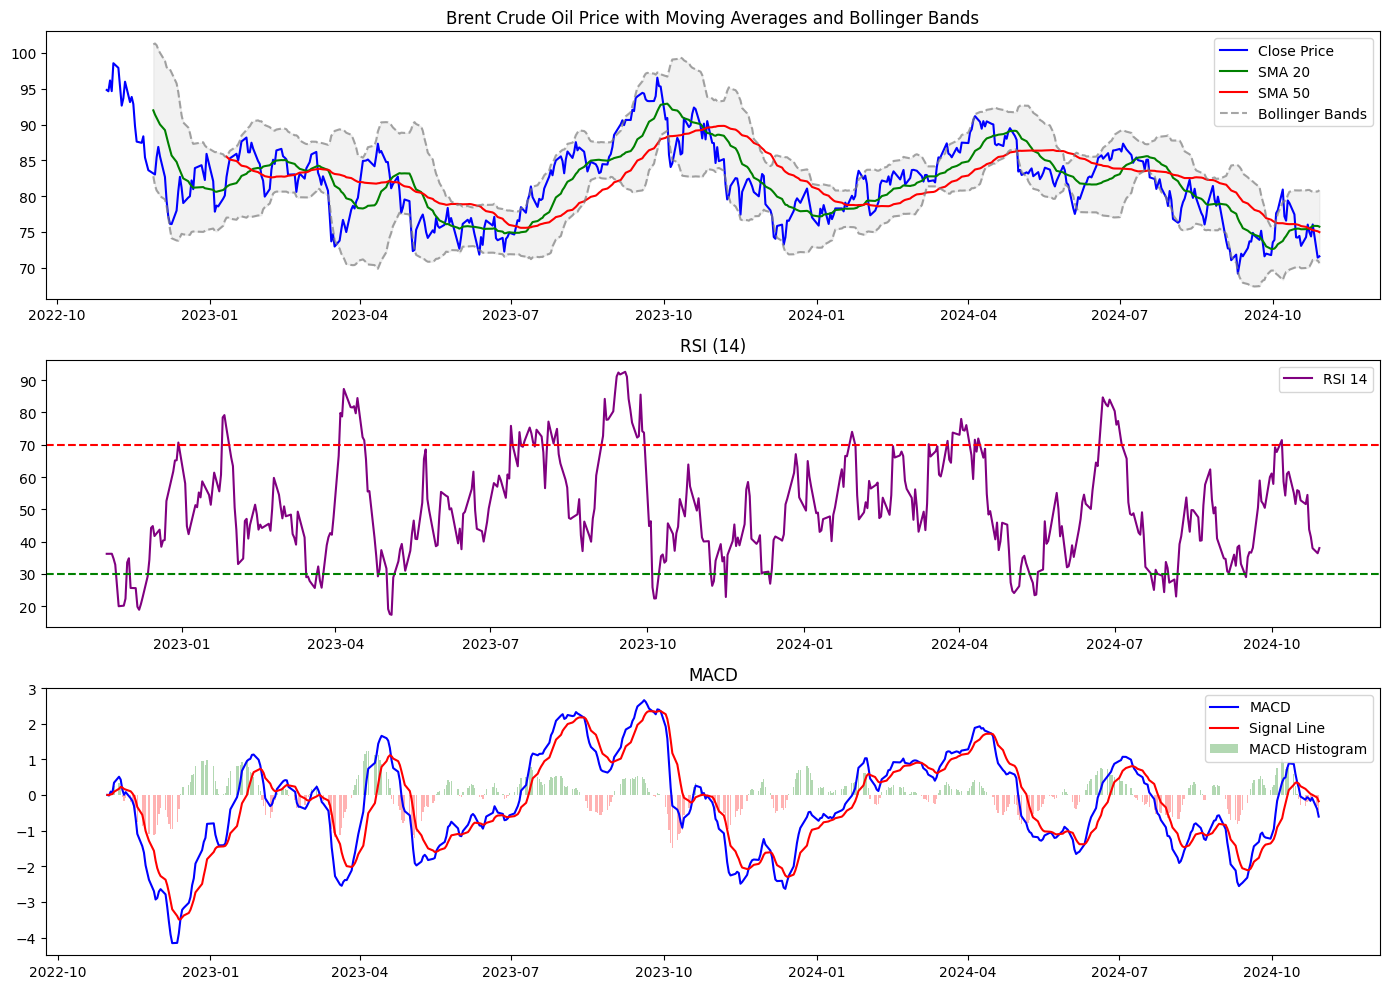

Brent crude oil data with technical indicators saved to 'brent_crude_with_indicators.csv'.

Market Analysis Summary:
Price Action (% change): 6M: -14.2%, 2M: -9.1%, 1M: -2.7%
RSI (37.99) is Neutral
Bollinger Bands position at 9.31% (Oversold)
MACD is Bearish with histogram at -0.4298

Overall Market Sentiment: Moderately Bullish
Bullish Signals: 2, Bearish Signals: 1


<ipython-input-60-2ecad49b3631>:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  '6m': float((df_6m['Close'].iloc[-1] - df_6m['Close'].iloc[0]) / df_6m['Close'].iloc[0] * 100),
<ipython-input-60-2ecad49b3631>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  '2m': float((df_2m['Close'].iloc[-1] - df_2m['Close'].iloc[0]) / df_2m['Close'].iloc[0] * 100),
<ipython-input-60-2ecad49b3631>:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  '1m': float((df_1m['Close'].iloc[-1] - df_1m['Close'].iloc[0]) / df_1m['Close'].iloc[0] * 100)
<ipython-input-60-2ecad49b3631>:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0])

In [62]:
if __name__ == "__main__":
    # Step 1: Get Brent Crude Oil data
    brent_data = get_brent_data()

    # Step 2: Calculate technical indicators
    brent_data_with_indicators = calculate_technical_indicators(brent_data)

    # Step 3: Plot indicators (optional)
    plot_indicators(brent_data_with_indicators)

    # Step 4: Save the data with indicators to CSV for further analysis
    brent_data_with_indicators.to_csv("brent_crude_with_indicators.csv")
    print("Brent crude oil data with technical indicators saved to 'brent_crude_with_indicators.csv'.")

    # Step 5: Analyze market conditions and print the result
    analysis_summary = analyze_market_conditions(brent_data_with_indicators)

    # Output analysis summary and sentiment to console
    print("\nMarket Analysis Summary:")
    for line in analysis_summary['text_summary']:
        print(line)
    print(f"\nOverall Market Sentiment: {analysis_summary['sentiment']}")
    print(f"Bullish Signals: {analysis_summary['bullish_signals']}, Bearish Signals: {analysis_summary['bearish_signals']}")